In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams["figure.figsize"] = (14, 6)

In [2]:
def run_once(f):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.has_run = True
            return f(*args, **kwargs)

    wrapper.has_run = False
    return wrapper

In [3]:
def get_index(r, nsup, lim=(-10, 10)):
    lo, hi = lim
    i = np.round((r - lo) / (hi - lo) * (nsup - 1))
    i = np.clip(i, 0, nsup - 1)
    return int(i)


def update_dist(r, probs, lim=(-10, 10), gamma=0.8):
    nsup = probs.shape[0]
    m = probs.clone()
    bj = get_index(r, nsup, lim)
    j = 1
    for i in range(bj, 1, -1):
        m[i] += np.power(gamma, j) * m[i - 1]
        j += 1
    j = 1
    for i in range(bj, nsup - 1, 1):
        m[i] += np.power(gamma, j) * m[i + 1]
        j += 1
    m = m / m.sum()
    return m

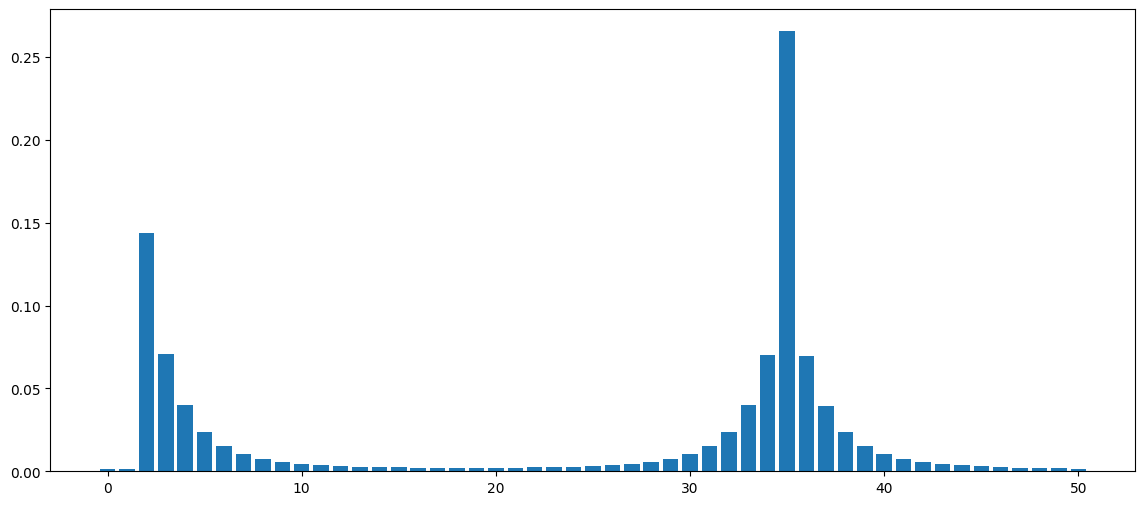

In [4]:
probs = torch.from_numpy(np.ones(51))
for _ in range(10):
    probs = update_dist(-9, probs)
for _ in range(10):
    probs = update_dist(4, probs)
plt.bar(range(51), probs);

In [5]:
def dist_dqn(x, theta, action_space=3):
    layer_dimensions = [(128, 100), (100, 25), *[(25, 51)] * action_space]
    layers = []
    e = 0
    for dim in layer_dimensions:
        s, e = e, e + np.prod(dim)
        layers.append(theta[s:e].reshape(dim))

    l1, l2, l3, l4, l5 = layers
    y = torch.selu(x @ l1)
    y = torch.selu(y @ l2)
    l3 = torch.stack([y @ l3, y @ l4, y @ l5], dim=1)
    l3 = torch.nn.functional.softmax(l3, dim=2)
    return l3.squeeze()

In [6]:
def get_target_dist(
    dist_batch, action_batch, reward_batch, support, lim=(-10, 10), gamma=0.8
):
    nsup = support.shape[0]
    target_dist_batch = dist_batch.clone()
    for i, (dist, action, reward) in enumerate(
        zip(dist_batch, action_batch, reward_batch)
    ):
        a = action.long().item()
        d = dist[a]
        if reward != -1:  # Terminal state, set the final reward.
            target_dist = torch.zeros(nsup)
            bj = get_index(reward, nsup, lim)
            target_dist[bj] = 1.0
        else:
            target_dist = update_dist(reward, d, lim=lim, gamma=gamma)
        target_dist_batch[i, a, :] = target_dist
    return target_dist_batch

In [7]:
def criterion(x, y):
    loss = torch.Tensor([0.0])
    loss.requires_grad = True
    for i in range(x.shape[0]):
        loss_ = -torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
    return loss

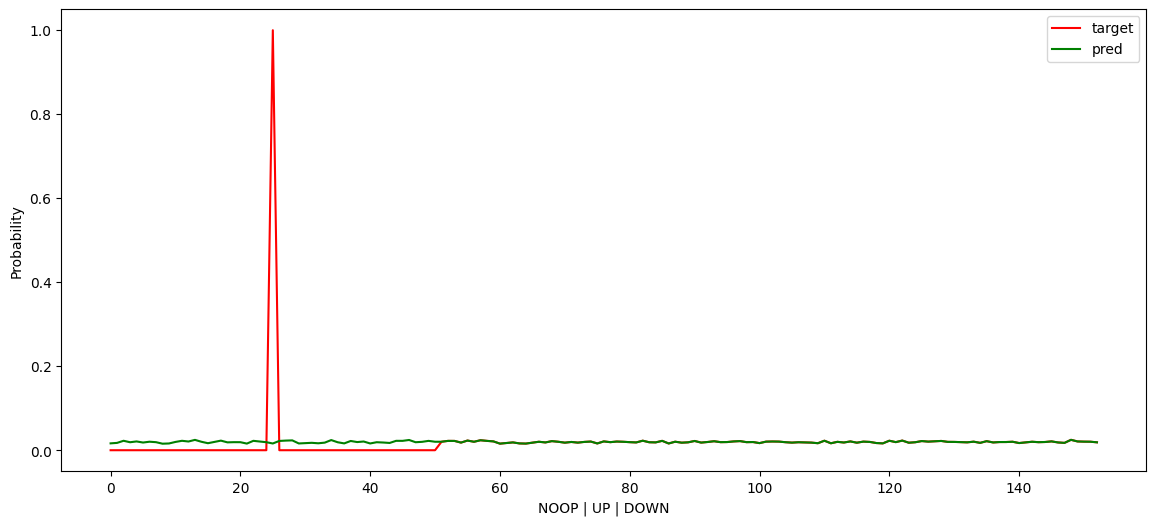

In [8]:
action_space = 3
total_params = 128 * 100 + 25 * 100 + action_space * 25 * 51
theta = torch.randn(total_params) / 10.0
theta.requires_grad = True
theta_2 = theta.detach().clone()
vmin, vmax = -10, 10
gamma = 0.9
lr = 1e-5
update_rate = 75


support = torch.linspace(-10, 10, 51)
state = torch.randn(2, 128) / 10.0
action_batch = torch.Tensor([0, 2])
reward_batch = torch.Tensor([0, 10])
losses = []
pred_batch = dist_dqn(state, theta, action_space=action_space)
target_dist = get_target_dist(
    pred_batch, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma
)


plt.plot(
    (target_dist.flatten(start_dim=1)[0].data.numpy()), color="red", label="target"
)
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()), color="green", label="pred")
plt.ylabel("Probability")
plt.xlabel("NOOP | UP | DOWN")
plt.legend();

In [9]:
for i in range(1000):
    reward_batch = torch.Tensor([0, 8]) + torch.randn(2) / 10.0
    pred_batch = dist_dqn(state, theta, action_space=action_space)
    pred_batch2 = dist_dqn(state, theta_2, action_space=action_space)
    target_dist = get_target_dist(
        pred_batch2, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma
    )
    loss = criterion(pred_batch, target_dist.detach())
    loss.backward()
    losses.append(loss.item())
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True

    if i % update_rate == 0:
        theta_2 = theta.detach().clone()

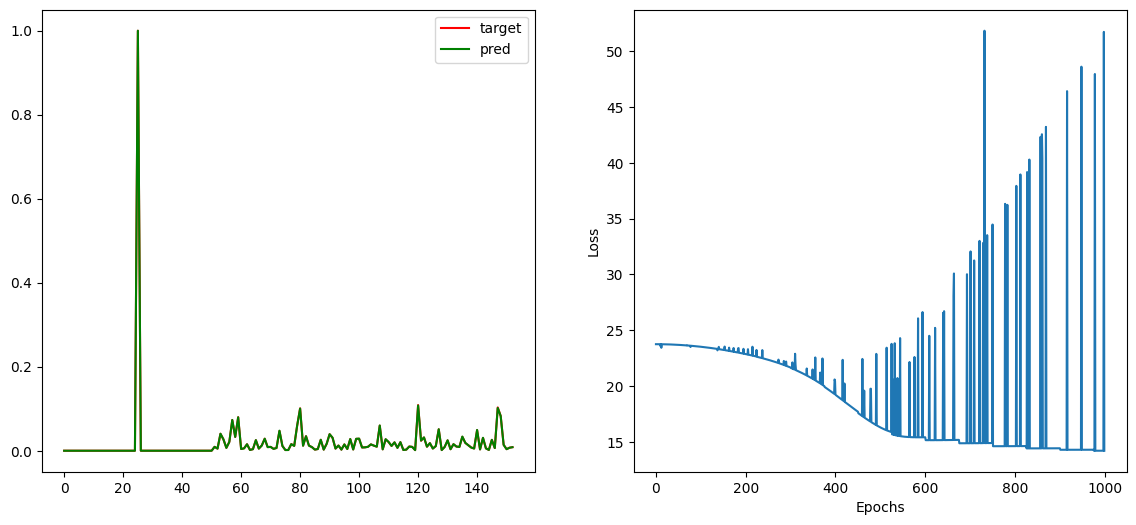

In [10]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(
    (target_dist.flatten(start_dim=1)[0].data.numpy()), color="red", label="target"
)
ax[0].plot(
    (pred_batch.flatten(start_dim=1)[0].data.numpy()), color="green", label="pred"
)
ax[0].legend()
ax[1].plot(losses)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss");

Visualizing the learned action-value distribution

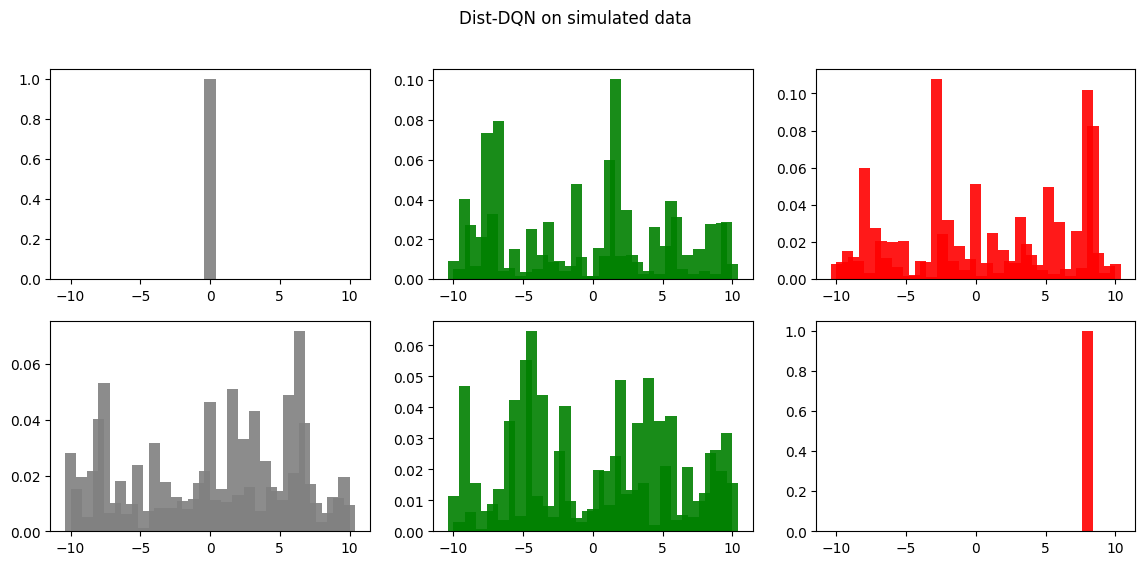

In [11]:
tpred = pred_batch
colors = ["gray", "green", "red"]
num_batch = 2
labels = [
    "Action {}".format(
        i,
    )
    for i in range(action_space)
]
fig, ax = plt.subplots(nrows=num_batch, ncols=action_space)
fig.suptitle("Dist-DQN on simulated data")
for j in range(num_batch):
    for i in range(tpred.shape[1]):
        ax[j, i].bar(
            support.data.numpy(),
            tpred[j, i, :].data.numpy(),
            label="Action {}".format(i),
            alpha=0.9,
            color=colors[i],
        )

In [12]:
def preprocess_state(state):
    state = torch.from_numpy(state).unsqueeze(dim=0).float()
    state = torch.nn.functional.normalize(state, dim=1)
    return state


def get_action(dist, support):
    actions = []
    for b in range(dist.shape[0]):
        expectations = [support @ dist[b, a, :] for a in range(dist.shape[1])]
        action = int(np.argmax(expectations))
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [13]:
import random
from collections import deque

import ale_py
import gymnasium as gym
import torch

# https://ale.farama.org/getting-started/


gym.register_envs(ale_py)
env = gym.make("ALE/Freeway-ram-v5")
action_space = 3
env.unwrapped.get_action_meanings()

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


['NOOP', 'UP', 'DOWN']

In [25]:
vmin, vmax = -10, 10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup - 1)
support = torch.linspace(vmin, vmax, nsup)
replay = deque(maxlen=replay_size)
lr = 1e-4
gamma = 0.1
epochs = 1300
eps = 0.20
eps_min = 0.05
priority_level = 5
update_freq = 25

# Initialize DQN parameter vector
total_params = 128 * 100 + 25 * 100 + action_space * 25 * 51
theta = torch.randn(total_params) / 10.0
theta.requires_grad = True
theta_2 = theta.detach().clone()
losses = []
cum_rewards = []
renders = []
observation, _info = env.reset()
state = preprocess_state(observation)

In [26]:
@run_once
def log_once(*args, **kwargs):
    print(args, kwargs)


for i in range(epochs):
    pred = dist_dqn(state, theta, action_space=action_space)
    if i < replay_size or np.random.rand(1) < eps:
        action = np.random.randint(action_space)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
    observation, reward, done, trunc, info = env.step(action)
    state2 = preprocess_state(observation)
    if reward == 1:
        cum_rewards.append(1)
    reward = 10 if reward == 1 else reward
    reward = -10 if done or trunc else reward
    reward = -1 if reward == 0 else reward
    exp = [state, action, reward, state2]
    replay.append(exp)

    if reward == 10:
        for e in range(priority_level):
            replay.append(exp)

    random.shuffle(replay)
    state = state2

    if len(replay) == replay_size:
        exps = random.sample(replay, batch_size)
        (state_batch, action_batch, reward_batch, state2_batch) = list(zip(*exps))

        state_batch = torch.stack(state_batch, dim=1).squeeze()
        action_batch = torch.Tensor(action_batch)
        reward_batch = torch.Tensor(reward_batch)
        state2_batch = torch.stack(state2_batch, dim=1).squeeze()

        pred_batch = dist_dqn(state_batch.detach(), theta, action_space=action_space)
        pred2_batch = dist_dqn(
            state2_batch.detach(), theta_2, action_space=action_space
        )

        target_dist = get_target_dist(
            pred2_batch,
            action_batch,
            reward_batch,
            support,
            lim=(vmin, vmax),
            gamma=gamma,
        )
        loss = criterion(pred_batch, target_dist.detach())
        loss.backward()
        losses.append(loss.item())
        with torch.no_grad():
            theta -= lr * theta.grad
        theta.requires_grad = True

    if i % update_freq == 0:
        theta_2 = theta.detach().clone()

    if i > 100 and eps > eps_min:
        dec = 1 / np.log2(i)
        dec /= 1e3
        eps -= dec

    if done:
        state = preprocess_state(env.reset()[0])
        done = False

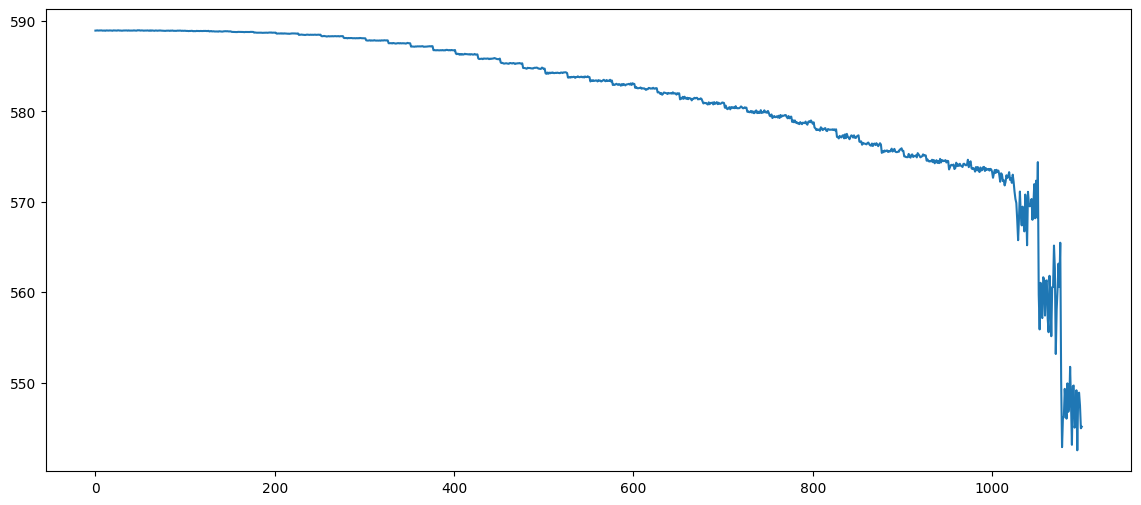

In [29]:
plt.plot(losses);

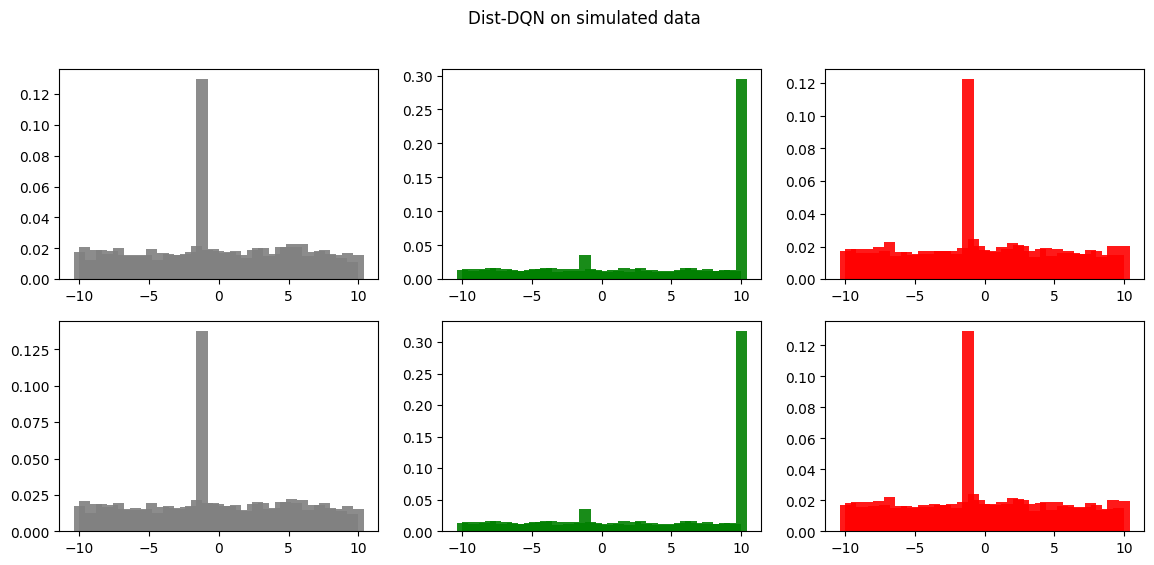

In [31]:
tpred = pred_batch
colors = ["gray", "green", "red"]
num_batch = 2
labels = [
    "Action {}".format(
        i,
    )
    for i in range(action_space)
]
fig, ax = plt.subplots(nrows=num_batch, ncols=action_space)
fig.suptitle("Dist-DQN on simulated data")
for j in range(num_batch):
    for i in range(tpred.shape[1]):
        ax[j, i].bar(
            support.data.numpy(),
            tpred[j, i, :].data.numpy(),
            label="Action {}".format(i),
            alpha=0.9,
            color=colors[i],
        )